In [1]:
import copy

file = open("adult.data", 'r')
line = file.readline().strip().lower()
first_line = copy.deepcopy(line)
line = line.split(', ')
line_len = len(line)

'''
data array stores one dictionary for each column 
with keys being all possible values of that column. 
The values are the frequencies of those keys.
'''

data = [{} for _ in range(line_len)]

'''
data_target dictionary categorizes the data based 
on the target and stores their occurrences.
'''

data_target = {True:[{} for _ in range(line_len-1)], False:[{} for _ in range(line_len-1)]}

line = first_line.replace('?', '').split(', ')
while line:
    for index in range(line_len-1):
        if line[index] == '':
            continue
        if line[index].strip() in data[index].keys():
            data[index][line[index].strip()]+=1
        else:
            data[index][line[index].strip()]=1
        if line[index] in data_target[line[-1]=='<=50k'][index].keys():
            data_target[line[-1]=='<=50k'][index][line[index].strip()]+=1
        else:
            data_target[line[-1]=='<=50k'][index][line[index].strip()]=1
    index+=1
    if line[index] == '':
        pass
    elif line[index].strip() in data[index].keys():
        data[index][line[index].strip()]+=1
    else:
        data[index][line[index].strip()]=1   
    line = file.readline()
    if line:
        line = line.strip().lower().replace('?', '').split(', ')

'''
There are some empty column values indicated by ? in the train data.
Those empty column values are ignored. So count of total non-empty values in each column may differ.
Hence to find the total non empty occurrences of the columns, total_occurences array is used.
'''

total_occurences = [sum(column.values()) for column in data]

'''
data_prob array holds the probaboilities of all possible values of the data.
'''

data_prob = [{key:value/total_occurences[index] for key, value in data[index].items()} for index in range(line_len)]

data_min_prob = min([min(dict_item.values()) for dict_item in data_prob])

'''
Data target probabilities are the conditional probabilities of the values given the target.
'''

data_target_prob = {True:[{} for _ in range(line_len-1)], False:[{} for _ in range(line_len-1)]}
con_min_prob = 1
for key,value in data_target.items():
    for in_ind in range(len(value)):
        for in_key in value[in_ind].keys():
            data_target_prob[key][in_ind][in_key] = value[in_ind][in_key]/data[-1]['<=50k'if key else '>50k']
            if data_target_prob[key][in_ind][in_key] < con_min_prob:
                con_min_prob = data_target_prob[key][in_ind][in_key]

'''
Calculate conditional minimum probability and 
data minimum probability(min prob of the value occuring in the train data)
to use for those values that occur in the test data but not in the train data.
'''
data_min_prob = data_min_prob/(10)
con_min_prob = con_min_prob/10
test = open("adult.test", 'r')
lines = 0
correct = 0
while True:
    line = test.readline() 
    if not line:
        break
    line = line.strip().lower().replace('?', '').split(', ')
    true_prob = 1
    false_prob = 1
    evidence_prob = 1
    for index in range(line_len-1):
        if line[index] == '':
            continue
        line[index] = line[index].strip()
        if line[index] in data_target_prob[True][index].keys():
            true_prob = true_prob*data_target_prob[True][index][line[index]]
        else:
            '''
            If this value is not present in the true dictionary, use the minimum conditional probability.
            '''
            true_prob = true_prob*con_min_prob
        if line[index] in data_target_prob[False][index].keys():
            false_prob = false_prob*data_target_prob[False][index][line[index]]
        else:
            '''
            If this value is not present in the false dictionary, use the minimum conditional probability.
            '''
            false_prob = false_prob*con_min_prob
        if line[index] in data_prob[index].keys():
            evidence_prob = evidence_prob*data_prob[index][line[index]]
        else:
            '''
            Marginalize over the empty value
            '''
            evidence_prob = evidence_prob*1
    index+=1
    true_prob = (true_prob/evidence_prob)*data_prob[-1]['<=50k']
    false_prob = ((false_prob/evidence_prob)*data_prob[-1]['>50k'])
    lines+=1
    if true_prob >= false_prob:
        if line[index] == '<=50k.':
            correct+=1
    elif line[index] == '>50k.':
        correct+=1
print((correct/lines)*100)

83.36097291321171


In [ ]:
import re
import string
import nltk

stop_words = set(nltk.corpus.stopwords.words('english'))
from nltk.stem import PorterStemmer
stemmer= PorterStemmer()
from nltk.stem import WordNetLemmatizer
lemmatizer=WordNetLemmatizer()

file = open("SMSSpamCollection", 'r')
word_count = {}
word_count_target={'spam':{}, 'ham':{}}
spam = 0
ham = 0
lines = len(file.readlines())
file.close()
test = int(lines*0.3)
train = lines-test
spam_lines = 0
file = open('SMSSpamCollection', 'r')
for _ in range(train):
    line = file.readline().strip().lower()
    if not line:
        continue
    line = re.sub(r'\d+', '', line)
    line = line.translate(line.maketrans("","",string.punctuation))
    line = line.split()
    target = line.pop(0)
    line = set(line)-stop_words
    line = [lemmatizer.lemmatize(stemmer.stem(word)) for word in line]
    if target == 'spam':
        spam_lines += 1
    for word in line:
        word = word.strip()
        if word in word_count.keys():
            word_count[word] += 1
        else:
            word_count[word] = 1
        if target=='spam':
            if word in word_count_target['spam'].keys():
                word_count_target['spam'][word] += 1
            else:
                word_count_target['spam'][word] = 1
        else:
            if word in word_count_target['ham'].keys():
                word_count_target['ham'][word] += 1
            else:
                word_count_target['ham'][word] = 1

total_words = sum(word_count.values())
word_prob = {key:value/total_words for key, value in word_count.items()}

total_spam_words = sum(word_count_target['spam'].values())
total_ham_words = total_words-total_spam_words
word_target_prob = {'spam':{key:value/total_spam_words for key, value in word_count_target['spam'].items()}, \
                        'ham':{key:value/total_ham_words for key,value in word_count_target['ham'].items()}}

distinct_spam_words = len(word_count_target['spam'].keys())
distinct_ham_words = len(word_count_target['ham'].keys())
stat_spam_prob = spam_lines/lines
stat_ham_prob = 1-stat_spam_prob

correct = 0
for _ in range(test):
    line = file.readline().strip().lower()
    if not line:
        continue
    line = re.sub(r'\d+', '', line)
    line = line.translate(line.maketrans("","",string.punctuation))
    line = line.split()
    target = line.pop(0)
    line = set(line)-stop_words
    line = [lemmatizer.lemmatize(stemmer.stem(word)) for word in line]
    ham_prob = stat_ham_prob
    spam_prob = stat_spam_prob
    s_words = distinct_spam_words
    h_words = distinct_ham_words
    for word in line:
        if word not in word_target_prob['spam'].keys():
            s_words += 1
        if word not in word_target_prob['ham'].keys():
            h_words += 1
    for word in line:
        word = word.strip()
        if word in word_target_prob['spam'].keys():
            spam_prob *= (word_target_prob['spam'][word] + (1/s_words))
        else:
            spam_prob *= (1/s_words)
        if word in word_target_prob['ham'].keys():
            ham_prob *= (word_target_prob['ham'][word] + (1/h_words))
        else:
            ham_prob *= (1/h_words)
    if (spam_prob/(spam_prob+ham_prob)) > 0.5:
        if target == 'spam':
            correct += 1
    elif target == 'ham':
        correct += 1
print(correct*100/test)

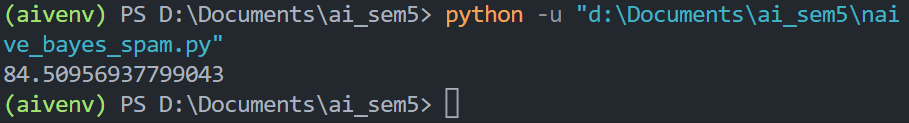